#  Laboratorio 4

##### Gladys Andrea Rodríguez Guerrero  -  20006107

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import joblib

In [37]:
# Despliegue maximo de columnas
pd.pandas.set_option('display.max_columns', None)

In [38]:
data = pd.read_csv('train.csv')
data.drop('Name', axis=1, inplace=True)
print(data.shape)
data.head()

(891, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
# Se separa data para train y test
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(['PassengerId', 'Survived'], axis=1),
                        data['Survived'],
                        test_size=0.15,
                        random_state=2021)

X_train.shape, X_test.shape

((757, 9), (134, 9))

### Transformación del Target a Gausssiano

In [40]:
# No se usa np.log por datos negatvos, genera error

y_train = np.sqrt(np.power(y_train,2))
y_test = np.sqrt(np.power(y_test,2))
#y_train
#y_test

### Missing Values

##### * Missing Values para Variables Categóricas

In [41]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
#cat_vars

#Agregamos variables que por definición son categóricas
cat_vars = cat_vars + ['Pclass'] + ['SibSp'] + ['Parch']
#cat_vars

In [42]:
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

# Cantidad de variables categóricas
len(cat_vars)

7

##### * 2.1.1 Detección de NaN en variables categórias

In [8]:
cat_vars_with_na = [var for var in cat_vars 
                        if X_train[var].isnull().sum() > 0]

cat_vars_with_na

['Cabin', 'Embarked']

In [43]:
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending = False)

Series([], dtype: float64)

In [46]:
# variables tratadas con etiqueta de faltante por cantidad masiva de faltantes.
vars_with_missing_string = [var for var in cat_vars_with_na
                               if X_train[var].isnull().mean() > 0.2]

# variables tratadas con procedimiento por candiad adecuada de faltantes.
vars_freq_category = [var for var in cat_vars_with_na
                               if X_train[var].isnull().mean() <= 0.2]

#vars_with_missing_string

#vars_freq_category

[]

##### Aplicamos cirterio para tratar data faltante

In [11]:
# Faltantes con etiqueta missing
X_train[vars_with_missing_string] = X_train[vars_with_missing_string].fillna('Missing')
X_test[vars_with_missing_string] = X_test[vars_with_missing_string].fillna('Missing')

In [12]:
for var in vars_freq_category:
    mode = X_train[var].mode()[0]
    
    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)
    
    print(var, "-------", mode)

Embarked ------- S


In [13]:
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending = False)

Embarked    0.0
Cabin       0.0
dtype: float64

In [14]:
cat_vars_with_na = [var for var in cat_vars 
                        if X_train[var].isnull().sum() > 0]
cat_vars_with_na

[]

##### * Missing Values para Variables Númericas

In [47]:
num_vars = [var for var in X_train.columns
               if var not in cat_vars and var != 'Survived']
len(num_vars)
num_vars

['Age', 'Fare']

In [16]:
# Numéricas con faltantes
num_vars_with_na = [var for var in num_vars
                       if X_train[var].isnull().sum() > 0]
#num_vars_with_na

In [17]:
X_train[num_vars_with_na].isnull().mean()

Age    0.200793
dtype: float64

##### Aplicamos cirterio para tratar data faltante

In [18]:
for var in num_vars_with_na:
    mean_val = X_train[var].mean()
    
    print(var, mean_val)
    
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

Age 29.51267768595041


In [19]:
X_train[num_vars_with_na].isnull().mean()

Age    0.0
dtype: float64

### Variables Temporales

------------- El dataset no contiene variables temporales -------------

### Transformación de Variables Numéricas

In [20]:
#Aplicamos transformación logaritmica para variables nuemricas
for var in ['Fare']:
    X_train[var] = np.sqrt(np.power(X_train[var],2))
    X_test[var] = np.sqrt(np.power(X_test[var],2))

##### * Binarización de Variables con Sesgo fuerte

In [21]:
sesgadas = ['Fare']

for var in sesgadas:
    X_train[var] = np.where(X_train[var] == 0, 0, 1)
    X_test[var] = np.where(X_test[var] == 0, 0, 1)

### Codificación de Variables Categóricas

In [22]:
# Mapeo ordinal de categorías de calidad

sex_mapping = {'male':1, 'female':0}

X_train['Sex'] = X_train['Sex'].map(sex_mapping)
X_test['Sex'] = X_test['Sex'].map(sex_mapping)

##### Codificación de Raras (baja frecuencia)

In [23]:
qual_vars = ['Fare']
other_cat = [var for var in cat_vars if var not in qual_vars]
other_cat

['Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass', 'SibSp', 'Parch']

In [24]:
len(other_cat)

7

In [25]:
#funcion para encontar etiquetas raras (determinar la proporcion de rareza)
def find_rare_labels_freq(df, var, rare_perc):
    temp = df.groupby(var)[var].count()/len(df)
    return temp[temp > rare_perc].index

In [26]:
for var in other_cat:
    freqValue = find_rare_labels_freq(X_train, var, 0.01)
    
    #print(var, '--------', freqValue)
    
    X_train[var] = np.where(X_train[var].isin(freqValue), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(freqValue), X_test[var], 'Rare')

In [27]:
def replace_category_vals(train, test, y_train, var, target):
    
    temp = pd.concat([train, y_train], axis=1) 
    order_labels = temp.groupby([var])[target].mean().sort_values().index
    
    ordinal_values = {k: i for i, k in enumerate(order_labels, 0)}
    
    print(var, ordinal_values)
    
    train[var] = train[var].map(ordinal_values)
    test[var] = test[var].map(ordinal_values)

In [28]:
for var in other_cat:
    replace_category_vals(X_train, X_test, y_train, var, 'Survived')

Sex {'1': 0, '0': 1}
Ticket {'Rare': 0}
Cabin {'Missing': 0, 'Rare': 1}
Embarked {'S': 0, 'Q': 1, 'C': 2}
Pclass {3: 0, 2: 1, 1: 2}
SibSp {'Rare': 0, 4: 1, 3: 2, 0: 3, 2: 4, 1: 5}
Parch {'Rare': 0, 0: 1, 2: 2, 1: 3}


In [29]:
def analyse_other_cats(train, y_train, var):
    temp = pd.concat([train, y_train], axis=1)

    temp.groupby(var)['Survived'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Survived')
    plt.show()

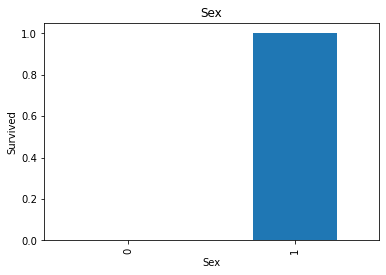

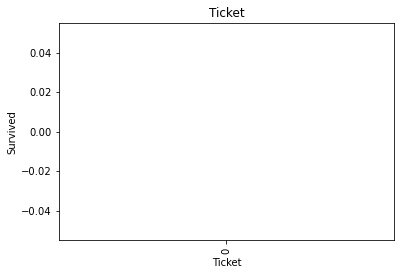

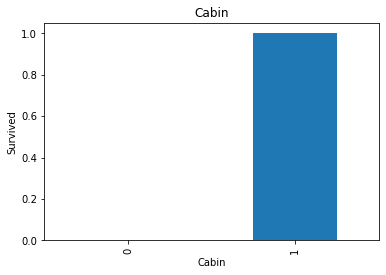

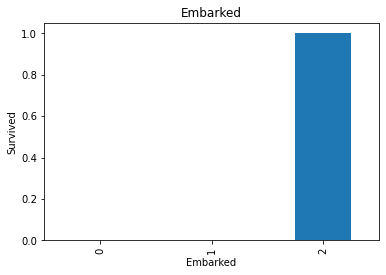

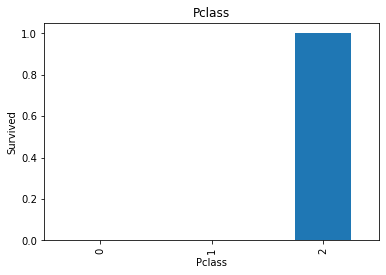

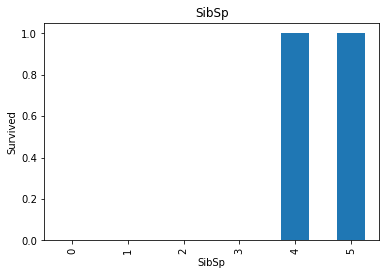

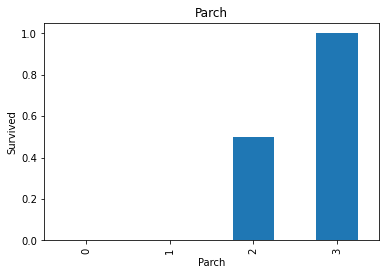

In [30]:
for var in other_cat:
    analyse_other_cats(X_train, y_train, var)

### Feature Scaling

In [31]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)


X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [32]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,1.0,0.560191,1.0,1.000000,0.0,1.0,0.0,0.0
1,0.5,0.0,0.308872,1.0,0.666667,0.0,1.0,0.0,1.0
2,0.0,0.0,0.365578,0.6,0.333333,0.0,1.0,0.0,0.0
3,0.0,1.0,0.120382,0.6,0.666667,0.0,1.0,0.0,0.0
4,0.0,1.0,0.195778,0.6,0.333333,0.0,1.0,0.0,0.5


In [33]:
#Se guarda dataset con data preparada para entrenamiento.

X_train.to_csv('preprocess_data/prep_Xtrain.csv', index=False)
X_test.to_csv('preprocess_data/prep_Xtest.csv', index=False)

y_train.to_csv('preprocess_data/prep_ytrain.csv', index=False)
y_test.to_csv('preprocess_data/prep_ytest.csv', index=False)

In [34]:
joblib.dump(scaler, 'preprocess_data/minmax_scaler.joblib')

['preprocess_data/minmax_scaler.joblib']

In [35]:
np.sum(X_train[X_train == 'Unf'].sum(axis=0))

0.0